# XLP strategy

Let's test a trading strategy described on the [Quantified Strategies](http://www.quantifiedstrategies.com/trade-the-boring-consumer-stocks-when-they-open-down-and-yesterday-was-a-down-day/) blog.  <br>




In [1]:
%pylab inline
%run common.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tradingWithPython as twp
import tradingWithPython.lib.yahooFinance as yf # yahoo finance functions
from tradingWithPython import sharpe # general trading toolbox functions
import pandas as pd # pandas time series library



In [3]:
ohlc = yf.getHistoricData('XLP')[['open','high','low','close']] # get data from yahoo finance


Got 4588 days of data


In [4]:
ohlc.tail()

,open,high,low,close
Date,,,,
2018-03-21,52.29,52.50,51.82,51.93
2018-03-22,51.78,52.19,51.46,51.50
2018-03-23,51.68,51.89,50.81,50.86
2018-03-26,51.24,51.64,51.08,51.59
2018-03-27,51.68,52.10,51.33,51.56


Trading volume is not needed for this strategy, so I remove it for now.

             open   high    low  close
Date                                  
1999-12-31  23.02  23.19  22.89  23.03
2000-01-03  23.12  23.12  22.47  22.75
2000-01-04  22.31  22.66  22.08  22.11
2000-01-05  22.27  22.61  22.09  22.50
2000-01-06  22.66  23.00  22.48  22.92
...           ...    ...    ...    ...
2018-03-21  52.29  52.50  51.82  51.93
2018-03-22  51.78  52.19  51.46  51.50
2018-03-23  51.68  51.89  50.81  50.86
2018-03-26  51.24  51.64  51.08  51.59
2018-03-27  51.68  52.10  51.33  51.56

[4588 rows x 4 columns]


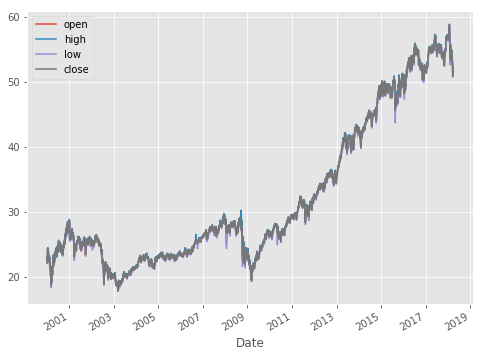

In [5]:
ohlc.plot()
print(ohlc)

The strategy rules are:

* Yesterday must have been a down day of at least 0.25%.
* If XLP opens down more than 0.1% today, go long and exit on the close.


Sharpe buy-and-hold: 0.372976063661


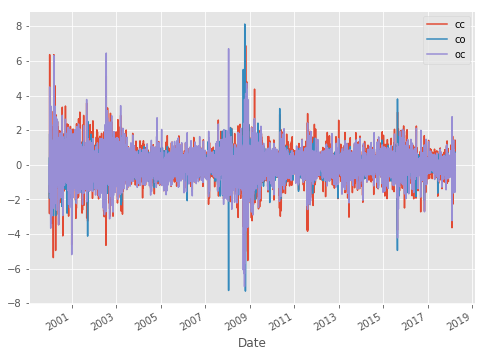

In [6]:
stratData = pd.DataFrame(index=ohlc.index)
stratData['cc'] = 100*ohlc['close'].pct_change() # close-to-close change in %
stratData['co'] = 100*(ohlc['open']/ohlc['close'].shift(1)-1) # previous close to open change in %
stratData['oc'] = 100*(ohlc['close']/ohlc['open']-1) # open to close change in %
stratData.plot()
print('Sharpe buy-and-hold:', sharpe(stratData['cc']))

Let's take a look how these CC, CO and OC returns accumulate over time

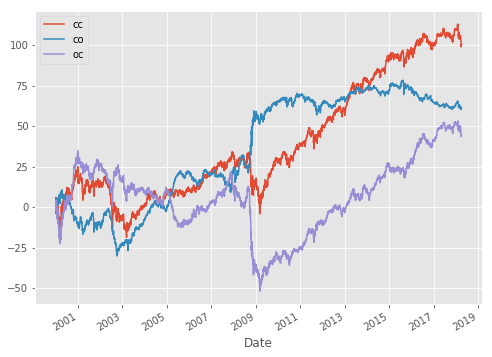

In [7]:
stratData.cumsum().plot(grid=True)

Clearly most of the returns are occuring overnight, from close to open. 

Now let's simulate the strategy.


In [15]:
idx = (stratData['cc']<-0.25).shift(1) & (stratData['co'] < -0.1) # find days that satisfy the strategy rules
idx[0] = False # fill first entry with False (needed because .shift(1) adds a NaN in the first element)

stratData['goLong'] = idx
stratData['pnl'] = 0. # init pnl column with zeros (Watch out: if initialized with integer value (0), an error will pop later on)
stratData.loc[idx,'pnl'] = stratData.loc[idx,'oc'] # set pnl column values to daily return wehere 'goLong' is true

stratData.tail(20) # show last 10 rows of stratData 

,cc,co,oc,goLong,pnl
Date,,,,,
2018-02-28,-1.04,0.59,-1.62,False,0.00
2018-03-01,-0.22,-0.24,0.02,True,0.02
2018-03-02,0.84,-0.38,1.22,False,0.00
2018-03-05,0.87,-0.54,1.42,False,0.00
2018-03-06,0.07,0.04,0.04,False,0.00
...,...,...,...,...,...
2018-03-21,-1.24,-0.55,-0.69,True,-0.69
2018-03-22,-0.83,-0.29,-0.54,True,-0.54
2018-03-23,-1.24,0.35,-1.59,False,0.00


Sharpe: 1.00708745001


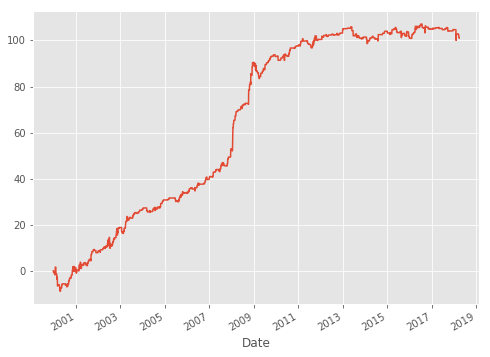

In [16]:
print('Sharpe:' , sharpe(stratData['pnl']))
stratData['pnl'].cumsum().plot()

Ok, this is nice. The result matches with what Oddmund have found. <br> 
But this is actually where the fun really starts, now I'll backtest this strategy with different parameters and also test it on other symbols. <br>
First, let's rewrite the strategy as a function so it is easy to use.

## Rewrite strategy to a single function

Here I'll just copy & paste all the code written above and put it into a function, which returns the pnl timeseries.

In [17]:
def backtest(ohlc, ccThresh=-0.25, coThresh=-0.1):
    ''' Function to backtest the Boring Consumer Stocks strategy '''
    stratData = pd.DataFrame(index=ohlc.index)
    stratData['cc'] = 100*ohlc['close'].pct_change() # close-to-close change in %
    stratData['co'] = 100*(ohlc['open']/ohlc['close'].shift(1)-1) # previous close to open change in %
    stratData['oc'] = 100*(ohlc['close']/ohlc['open']-1) # open to close change in %
    
    idx = (stratData['cc']<ccThresh).shift(1) & (stratData['co'] < coThresh) # find days that satisfy the strategy rules
    idx[0] = False # fill first entry with False (needed because .shift(1) adds a NaN in the first element)

    stratData['goLong'] = idx
    stratData['pnl'] = 0. # init pnl column with zeros (Watch out: if initialized with integer value (0), an error will pop later on)
    stratData.loc[idx,'pnl'] = stratData.loc[idx, 'oc'] # set pnl column values to daily return wehere 'goLong' is true

    return stratData['pnl']
    

Now, test the function with OHLC data, result should be exactly as before

Sharpe: 1.00708745001


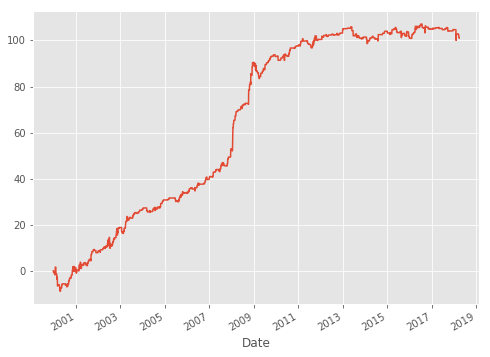

In [18]:
pnl = backtest(ohlc)
pnl.cumsum().plot()
print('Sharpe:', sharpe(pnl))

Indeed, same result. Now we can proceed to scanning parameter values.

## Make a scan of ALL parameters 
We'll also use a nice progress bar to display calculation progress

[ref]: # (plotting - heatmap)
[ref]: # (backtesting - parameter scan)

 [*********************100%***********************]  29 of 29 complete

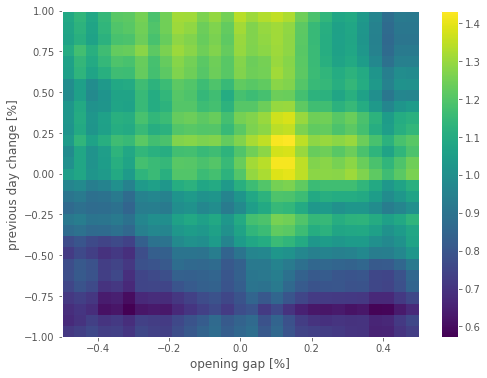

In [19]:
from tradingWithPython.lib.extra import ProgressBar

ccThresh = np.linspace(-1,1,30)
coThresh = np.linspace(-0.5,0.5, 30)

SH = np.zeros((len(ccThresh),len(coThresh)))

pbar = ProgressBar(len(ccThresh)-1)

for i, cc in enumerate(ccThresh):
    pbar.animate(i)
    for j, co in enumerate(coThresh):
        pnl = backtest(ohlc, ccThresh=cc, coThresh=co)
        SH[i,j] = sharpe(pnl)
        
pcolor(coThresh,ccThresh, SH)
xlabel('opening gap [%]')
ylabel('previous day change [%]');
colorbar();

No find the ompimal parameters corresponding to maximum Sharpe ratio.

In [20]:
i,j = np.unravel_index(SH.argmax(), SH.shape)
SH[i,j]
print('Optimum CC %.2f' % ccThresh[i])
print('Optimum CO %.2f' % coThresh[j])

Optimum CC 0.17
Optimum CO 0.12


Sharpe: 1.40688387138


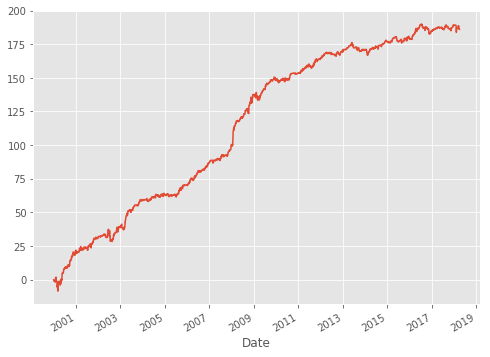

In [21]:
pnl = backtest(ohlc, ccThresh = 0.03, coThresh= 0.09)
print('Sharpe:', sharpe(pnl))
_ = pnl.cumsum().plot()

## Conclusion

The rules of -0.25% / -0.1% can be further improved to achieve a higher Sharpe. However, the strategy performance does not vary that much, it is very stable and performs well for a wide range of settings

## Improvements

### Walk-Forward Optimization

[ref]: # (backtesting - walk-forward)

In order to avoid [curve-fitting](http://en.wikipedia.org/wiki/Curve_fitting), we will perform a [walk-forward optimization](http://en.wikipedia.org/wiki/Walk_forward_optimization)

* http://www.easyexpertforex.com/walk-forward-analysis.html

* http://www.tradestation.com/trading-technology/tradestation-platform/analyze/walk-forward-optimizer

A neat way to do this is to create a function that generates two datasets: in- and out-of-sample. The first one is used to optimize the strategy, second one to test its performance. 
The function `generateFWD` below does just that. Take a look at the [generator concept](http://docs.python.org/2/tutorial/classes.html#tut-generators) used in this function. In this way the `yield` of the function can be used in a loop: 

`for trainSet,testSet, tp in generateFWD(ohlc)`

In [22]:
def generateFWD(data,nTrain = 250, nTest=50):
    ''' 
    Walk forward generator. Returns two subsections (in-sample, out-of-sample) of provided dataframe to 
    be used in a walk-forward testing.
    
    Parameters
    -------------
    data : DataFrame containing full dataset
    nTrain : number of periods in a train (in-sample) set
    nTest : number of periods in a test (out-of-sample) set
    
    Returns
    ----------
    (trainSet,testSet,testPoint)
    
    '''
    nTotal = nTrain+nTest
    
    for tp in range(nTrain,len(data) - nTotal, nTest) :  # xrange() is a little more efficient than range()
        # tp is a 'testpoint' which is at in-sample/out-of-sample boundary
        yield (data.iloc[tp-nTrain:tp,:], data.iloc[tp:tp+nTest],tp) # return test and train datasets

def optimize(ohlc):
    ''' find optimal strategy parameters '''
    ccThresh = np.linspace(-1,1,30)
    coThresh = np.linspace(-0.5,0.5, 30)
    
    SH = np.zeros((len(ccThresh),len(coThresh)))
    
    for i, cc in enumerate(ccThresh):
        for j, co in enumerate(coThresh):
            pnl = backtest(ohlc, ccThresh=cc, coThresh=co)
            SH[i,j] = sharpe(pnl)
            
    i,j = np.unravel_index(SH.argmax(), SH.shape)
    SH[i,j]
    
    return ccThresh[i], coThresh[j]  
   
nTest = 250    # number of days in testing period
pnl = []       # results of individual tests, will be combined to a single series later

#we'll need some work to prepare the progress bar by first generating the testpoints. ProgressBar is optional of course.
testPoints = [ tp for _,_,tp in generateFWD(ohlc, nTest=nTest)]
    
pbar =ProgressBar(len(testPoints)-1)    
    
for trainSet,testSet, tp in generateFWD(ohlc,nTest=nTest):
    (cc,co) = optimize(trainSet)
    pnl.append(backtest(testSet, ccThresh = cc, coThresh= co))
    pbar.animate(testPoints.index(tp))

 [****************      33%                       ]  5 of 15 complete

/home/jev/Development/tradingWithPython/lib/functions.py:294: RuntimeWarning: invalid value encountered in double_scalars
  return  np.sqrt(250)*pnl.mean()/pnl.std()


 [*********************100%***********************]  15 of 15 complete

Sharpe: 1.40


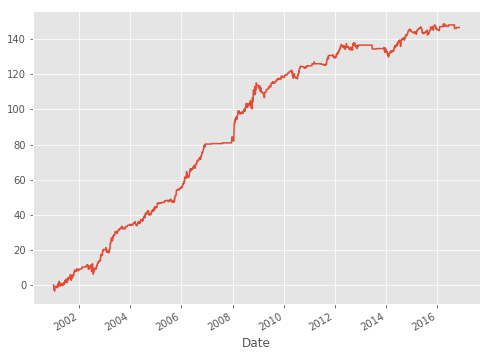

In [23]:
PNL = pd.concat(pnl) # combine to a single series
PNL.cumsum().plot()

print('Sharpe: %.2f' % sharpe(PNL))

So, the strategy seems to perform quite well out-of-sample